# Urban sound dataset

In [2]:
import os
import librosa

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

from scipy import signal 
from scipy.optimize import minimize
from scipy.spatial.distance import euclidean

from softmax import *
from exact_barycenter import *

matplotlib.rcParams.update({'font.size': 16})
folder = '/Users/ard/Downloads/UrbanSound8K/'
#folder = './data/UrbanSound8K/'
df = pd.read_csv("{}metadata/UrbanSound8K.csv".format(folder))
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


# Load and preprocess data

In [3]:
# use the predifined folds !

def path_class(filename, folder=folder):
    excerpt = df[df['slice_file_name'] == filename]
    path_name = os.path.join('{}/audio'.format(folder), 'fold' + str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0], excerpt.fold.values[0]

def wav_player(full_path, class_label, fold):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path), fold

In [6]:
labels = []
psds = []
folds = []

for n, salience in zip(df.slice_file_name[:], df.salience):
    if salience == 2: # signal as background noise
        continue
    full_path, label, fold = path_class(n)
    
    try:
        sig, rate = librosa.load(full_path, sr=None)
        if not rate == 44100:
            continue
        _ , psd = signal.periodogram(sig, fs=rate, nfft=1000)
        if np.count_nonzero(psd) == 0:
            print("zero vector removed")
            continue
        
        psds.append(psd)
        labels.append(label)
        folds.append(fold)
        
    except Exception as e:
        print("cannot read " + n, e)

labels = np.array(labels)
#rates = np.array(rates)
psds = np.array(psds)
folds = np.array(folds)

#np.save("data/urban_labels", labels)
#np.save("data/urban_psds", psds)
#np.save("data/urban_folds", folds)

zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed
zero vector removed


NameError: name 'rates' is not defined

In [4]:
labels = np.load("./data/urban_labels.npy")
psds = np.load("./data/urban_psds.npy")
folds = np.load("./data/urban_folds.npy")

full_path, label, _ = path_class(df.slice_file_name[0])
wav_sample, rate = librosa.load(full_path)
support, s = signal.periodogram(wav_sample, nfft=1000)

for i in range(len(psds)):
    psds[i,:] /= np.sum(psds[i,:])

names = np.unique(labels)
for n in names:
    print(n, np.sum(labels==n))
    
print('total {}'.format(len(labels)))
print(psds.shape)

air_conditioner 442
car_horn 88
children_playing 324
dog_bark 367
drilling 646
engine_idling 455
gun_shot 132
jackhammer 408
siren 189
street_music 436
total 3487
(3487, 501)


In [10]:
_, counts = np.unique(folds, return_counts=True)
counts / np.sum(counts)

array([0.07771724, 0.09205621, 0.13363923, 0.05993691, 0.11155721,
       0.12188127, 0.09693146, 0.10983654, 0.09291655, 0.10352739])

In [6]:
def get_data(selection, folds, psds=psds, labels=labels):
    idx = []
    for s in selection:
        idx.extend(np.where(labels==s)[0])

    data = psds[idx, :]
    data_labels = labels[idx]
    folds = folds[idx]
    
    name2labels = dict()
    for i,n in enumerate(selection):
        name2labels[n] = i

    X = data
    y = np.array([name2labels[l] for l in data_labels])

    X += 1e-12
    for i in range(len(y)):
        X[i,:] /= np.sum(X[i,:])
    return X, y, folds


# Data description

0


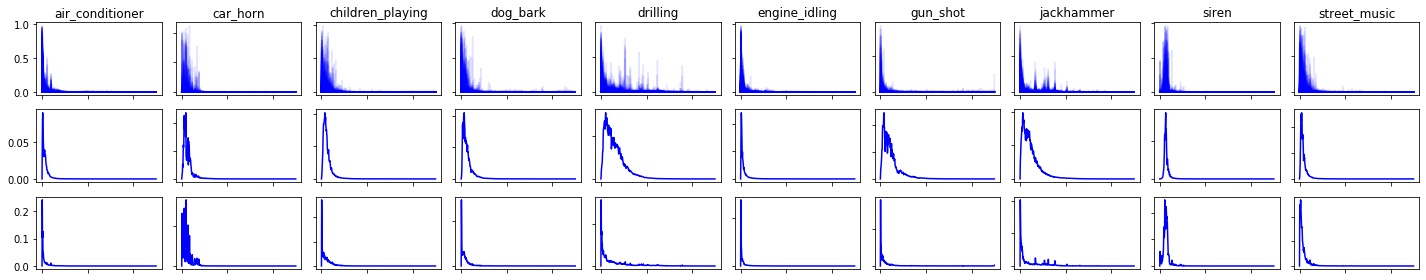

In [12]:
#selection = ['air_conditioner', 'gun_shot', 'jackhammer', 'drilling', 'engine_idling']

# engine idling VS siren
# gunshot jackhammer

selection = np.unique(labels)
X, y, _ = get_data(selection, folds) 
fig, ax = plt.subplots(3, len(selection), figsize=(20,4))  
plt.subplots_adjust(top=1, hspace=0.05, wspace=0.05)

for i, l in enumerate(selection):
    if not i:
        print(i)
        #ax[0,i].set_ylabel('UPSDs', rotation=0, labelpad=30, fontsize=16)
        #ax[1,i].set_ylabel('Wasserstein',rotation=0, labelpad=30, fontsize=16)
        #ax[2,i].set_ylabel('Euclidean',rotation=0, labelpad=30, fontsize=16)
    else:  
        plt.setp(ax[0,i].get_yticklabels(), visible=False)
        plt.setp(ax[1,i].get_yticklabels(), visible=False)
        plt.setp(ax[2,i].get_yticklabels(), visible=False)
    ax[0,i].set_title(selection[i])
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    plt.setp(ax[2,i].get_xticklabels(), visible=False)
    plt.setp(ax[2,0].get_xticklabels(), visible=True)
        
    #ax[0,i].set_ylim([0,1.])
    #ax[0, i].set_title(l, rotation=20, pad=40, fontsize=16)
    ax[0, i].plot(support, psds[labels==l].T, alpha=0.1, color='blue')
    
    q_bar, Finv, Finv_bar = get_barycenter(psds[labels==l], support, 10000, method='linear')
    #ax[1,i].set_ylim([0,0.12])
    ax[1, i].plot(support, q_bar, color='blue')
            
    l2_bar = np.mean(psds[labels==l], axis=0)
    #ax[2,i].set_ylim([0,0.29])
    ax[2, i].plot(support, l2_bar, color='blue')
plt.tight_layout()

#plt.savefig('plots/sound_summary_max.pdf')

0.6377097729516288


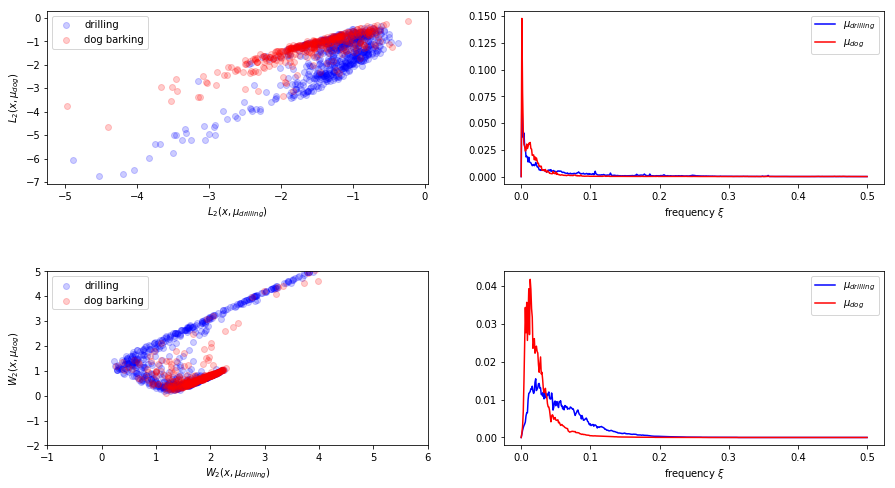

In [18]:
selection = ['drilling', 'dog_bark']
#selection = ['gun_shot', 'gun_shot']
X, y, _ = get_data(selection, folds)

wass = WSoftmax(X, y, support, distance='quantile', quadratic=False, options={'q_support': 1000})
eucl = WSoftmax(X, y, support, distance='euclidean', quadratic=False)
eucl = WSoftmax(X, y, support, distance='KL', quadratic=False)

fig, ax = plt.subplots(2,2,figsize=(15,8))
plt.subplots_adjust(hspace=0.5)

ax[0,0].scatter((eucl.W2b[y==0, 0 + 1]), (eucl.W2b[y==0, 1 + 1]), color='blue', alpha=0.2, label='drilling')
ax[0,0].scatter((eucl.W2b[y==1, 0 + 1]), (eucl.W2b[y==1, 1 + 1]), color='red', alpha=0.2, label='dog barking')
#ax[0,0].set_xlim([0,1])
#ax[0,0].set_ylim([0,1.5])
ax[0,1].plot(support, eucl.bars[0,:], color='blue', label='$\mu_{drilling}$')
ax[0,1].plot(support, eucl.bars[1,:], color='red', label='$\mu_{dog}$')
ax[0,0].legend(loc=2)
ax[0,1].legend()

ax[1,0].scatter((wass.W2b[y==0, 0 + 1]), (wass.W2b[y==0, 1 + 1]), color='blue', alpha=0.2, label='drilling')
ax[1,0].scatter((wass.W2b[y==1, 0 + 1]), (wass.W2b[y==1, 1 + 1]), color='red', alpha=0.2, label='dog barking')
ax[1,0].set_xlim([-1,6])
ax[1,0].set_ylim([-2,5])
ax[1,1].plot(support, wass.bars[0,:], color='blue', label='$\mu_{drilling}$')
ax[1,1].plot(support, wass.bars[1,:], color='red', label='$\mu_{dog}$')
ax[1,0].legend(loc=2)
ax[1,1].legend()


ax[0,1].set_xlabel(r"frequency $ \xi$")
ax[1,1].set_xlabel(r"frequency $ \xi$")
ax[0,0].set_xlabel(r"$L_2(x,\mu_{drilling})$")
ax[0,0].set_ylabel(r"$L_2(x,\mu_{dog})$")
ax[1,0].set_xlabel(r"$W_2(x,\mu_{drilling})$")
ax[1,0].set_ylabel(r"$W_2(x,\mu_{dog})$")

_, cc = np.unique(y, return_counts=True)
print(np.max(cc)/np.sum(cc))

fig.savefig('figures/drilling_vs_dog.pdf')


# Evaluation

In [16]:
np.random.seed(123)
# try all pairs of data : 
selection = np.unique(labels)
#selection = ['children_playing', 'dog_bark']
methods = ['quantile', 'euclidean', 'KL']
n_class = len(selection)
n_methods = len(methods)
quadratic = False
results = np.zeros((len(methods), n_class * (n_class - 1) // 2, 10)) # accuracy,
if quadratic:
    x0 = np.ones((4+1)*2) # initial parameters
else:
    x0 = np.ones((2+1)*2) # initial parameters
options_q = {'q_support': 1000}

idx = 0
for i in range(n_class):
    for j in range(i+1, n_class):
        candidate = [selection[i], selection[j]]
        X, y, f = get_data(candidate, folds)
         
        for m, method in enumerate(methods):
            scores = []
            for f_i, fold in enumerate(np.unique(f)):
                # use the predefined folds
                idx_te = f == fold
                idx_tr = f != fold
                X_tr = X[idx_tr, :]; X_te = X[idx_te, :] 
                y_tr = y[idx_tr]; y_te = y[idx_te] 
                y_tr = y_tr.reshape(-1,)
                N_te = len(y_te)

                model = WSoftmax(X_tr, y_tr, support, distance=method, quadratic=quadratic, options=options_q)
                res = minimize(fun=model.logp, x0=x0, jac=model.dlogp, method='L-BFGS-B')
                if not res['success']:
                    print('failed with {} on fold {} on task {} vs {}'.format(method, fold, selection[i], selection[j]))
                theta = res['x']
                prob, pred = model.pred(X_te, theta)
                pred = pred.reshape(y_te.shape)
        
                # store results
                results[m, idx, f_i] = np.sum(pred == y_te) / N_te

        idx += 1

In [17]:
df = pd.DataFrame()

tasks = []
for i in range(n_class):
    for j in range(i+1, n_class):
        tasks.append('{} {}'.format(selection[i], selection[j]))
        
df['task name'] = tasks

for m, name in enumerate(['W', 'L2', 'KL']):
    means = np.mean(results[m,:,:], axis=1)
    stds =  np.sqrt(np.sum((results[m,:,:].T - means)**2, axis=0)/9)
    stderr = stds / np.sqrt(10)

    df[name] = means
    df['{}_stderr'.format(name)] = stderr

df.to_csv('results/urban_sound_exp.csv')

In [18]:
df

,task name,W,W_stderr,L2,L2_stderr,KL,KL_stderr
0,air_conditioner car_horn,0.719932,0.078908,0.809213,0.067785,0.849536,0.059816
1,air_conditioner children_playing,0.656182,0.068462,0.630482,0.080641,0.672604,0.077674
2,air_conditioner dog_bark,0.588762,0.053518,0.623379,0.062893,0.649794,0.064667
3,air_conditioner drilling,0.756522,0.030280,0.715410,0.048731,0.741146,0.047671
4,air_conditioner engine_idling,0.556017,0.065276,0.564626,0.052143,0.544271,0.040844
5,air_conditioner gun_shot,0.732056,0.071894,0.717743,0.046505,0.650254,0.090303
6,air_conditioner jackhammer,0.791954,0.057361,0.665011,0.055530,0.737158,0.058995
7,air_conditioner siren,0.880323,0.050868,0.925883,0.030618,0.926223,0.029466
8,air_conditioner street_music,0.593069,0.057098,0.720592,0.050437,0.711980,0.063828
9,car_horn children_playing,0.807813,0.044336,0.814485,0.034364,0.851025,0.023103


In [27]:
from knn import *
np.random.seed(123)
# try all pairs of data : 
selection = np.unique(labels)
#selection = ['children_playing', 'dog_bark']
methods = ['quantile', 'euclidean', 'KL']
n_class = len(selection)
n_methods = len(methods)
quadratic = False
s = np.zeros((len(methods), n_class * (n_class - 1) // 2, 10)) # accuracy,


idx = 0
for i in range(n_class):
    for j in range(i+1, n_class):
        candidate = [selection[i], selection[j]]
        X, y, f = get_data(candidate, folds)
         
        for m, method in enumerate(methods):
            scores = []
            for f_i, fold in enumerate(np.unique(f)):
                # use the predefined folds
                idx_te = f == fold
                idx_tr = f != fold
                X_tr = X[idx_tr, :]; X_te = X[idx_te, :] 
                y_tr = y[idx_tr]; y_te = y[idx_te] 
                y_tr = y_tr.reshape(-1,)
                N_te = len(y_te)

                n_te, D = X_te.shape
                results = np.zeros(n_te)

                for test_i in range(n_te):
                    idx_neighbors = getNeighbors(X_tr, X_te[test_i, :], 6, method, support)
                    result = getResponse(y_tr[idx_neighbors])
                    results[test_i] = result
                    
                    # store results
                    s[m, idx, f_i] = np.sum(results.reshape(y_te.shape) == y_te) / len(y_te)

        idx += 1

In [28]:
print(s)

[[[0.84313725 0.96551724 0.78873239 ... 0.21621622 0.52631579 0.86842105]
  [0.73846154 0.72115385 0.54444444 ... 0.22222222 0.67567568 0.81052632]
  [0.64705882 0.63636364 0.46987952 ... 0.30666667 0.79069767 0.76041667]
  ...
  [1.         1.         0.98305085 ... 1.         1.         0.7       ]
  [0.83870968 0.88235294 0.51824818 ... 0.82352941 0.86734694 0.65957447]
  [0.90277778 0.83076923 0.87804878 ... 0.97142857 0.92753623 0.85964912]]

 [[0.90196078 0.95402299 0.71830986 ... 0.56756757 0.84210526 0.89473684]
  [0.58461538 0.52884615 0.52222222 ... 0.2037037  0.54054054 0.68421053]
  [0.72058824 0.47107438 0.56626506 ... 0.33333333 0.76744186 0.73958333]
  ...
  [1.         0.56666667 0.95762712 ... 0.928      0.97701149 0.6       ]
  [0.62903226 0.66666667 0.59854015 ... 0.71323529 0.82653061 0.55319149]
  [0.88888889 0.8        0.82926829 ... 0.91428571 0.88405797 0.85964912]]

 [[0.84313725 0.94252874 0.76056338 ... 0.54054054 0.84210526 0.90789474]
  [0.69230769 0.615384

In [30]:
df = pd.DataFrame()

tasks = []
for i in range(n_class):
    for j in range(i+1, n_class):
        tasks.append('{} {}'.format(selection[i], selection[j]))
        
df['task name'] = tasks

for m, name in enumerate(['W', 'L2', 'KL']):
    means = np.mean(s[m,:,:], axis=1)
    stds =  np.sqrt(np.sum((s[m,:,:].T - means)**2, axis=0)/9)
    stderr = stds / np.sqrt(10)

    df[name] = means
    df['{}_stderr'.format(name)] = stderr

In [31]:
df

,task name,W,W_stderr,L2,L2_stderr,KL,KL_stderr
0,air_conditioner car_horn,0.721146,0.095894,0.873555,0.042391,0.841459,0.045357
1,air_conditioner children_playing,0.619329,0.057786,0.532874,0.050454,0.596737,0.057132
2,air_conditioner dog_bark,0.578628,0.051507,0.623561,0.054913,0.558099,0.056772
3,air_conditioner drilling,0.709088,0.043772,0.687895,0.039461,0.724425,0.045647
4,air_conditioner engine_idling,0.592598,0.056607,0.534091,0.052711,0.583691,0.073154
5,air_conditioner gun_shot,0.686904,0.072354,0.598614,0.087972,0.588926,0.090979
6,air_conditioner jackhammer,0.742683,0.050550,0.610178,0.049424,0.675216,0.061239
7,air_conditioner siren,0.855506,0.051534,0.885993,0.032492,0.907002,0.020552
8,air_conditioner street_music,0.537680,0.045171,0.636523,0.040042,0.635736,0.054755
9,car_horn children_playing,0.817752,0.029263,0.806103,0.027258,0.839317,0.021177
